# Genuine Genres

An investigation of data munging, clustering, and dimensionality reduction through the medium of musical audio features.

*Can dimensionality reduction based on feature variance within and between output classes improve clustering?*

# Adding Audio Features

Our dataset was originally found from an individual account on GitHub (https://github.com/trebi/music-genres-dataset), which contains about 597,000 entries across 1,496 genres, each entry containing a song's unique Spotify id, track name, artist name, and track genre. I took that data, and isolated only the genres which had 400 or more songs in them (still over 1,200 genres and over 500,000 songs), then pulled audio features for each song and added it to the data. After over 12 hours of data collection from Spotify's API, all the data was safely and neatly stored in our audio_features.csv file.

The following code is what created all that...

## 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

base_dir = "drive/MyDrive/Courses/CS 539 - Machine Learning/genuine_genres/project_phillips/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Loading raw song data

In [2]:
# Use pandas.read_csv to read in the file,
# skipping the first row and specifying the delimiter as a semicolon
df = pd.read_csv(base_dir+"data/raw/songs.csv", skiprows=1, delimiter=';',
                 names=['track_id', 'track_name', 'artist_name', 'pos', 'track_genre'])

# Drop 'pos' column
df = df.drop('pos', axis=1)

df.head()

,track_id,track_name,artist_name,track_genre
0,6lV2MSQmRIkycDScNtrBXO,Airplanes (feat. Hayley Williams of Paramore),"B.o.B, Hayley Williams",pop rap
1,4hrae8atte6cRlSC9a7VCO,Always On Time,"Ja Rule, Ashanti",pop rap
2,03tqyYWC9Um2ZqU0ZN849H,No Hands [feat. Roscoe Dash and Wale],Waka Flocka Flame,pop rap
3,66TRwr5uJwPt15mfFkzhbi,Crank That (Soulja Boy),Soulja Boy,pop rap
4,3rMyMv8EjKXoPnaRo2hdJN,Stuntin' Like My Daddy - Street,"Birdman, Lil Wayne",pop rap


# 3. Descriptive statistics

Let's see a quick summary of the data

In [3]:
df.describe()

,track_id,track_name,artist_name,track_genre
count,579879,579878,579878,579878
unique,203843,178778,162833,1496
top,5nG6XQckfjnPkDyxDGDFFV,Alive,Various Artists,pop rap
freq,62,132,160,400


> Analysis:

> We can see we have 1496 unique genres, 162,833 unique artists, and 203,843 unique tracks (12.3% of which have the same track_name as another track)

> IMPORTANT NOTE:

> Eventually, every entry will be populated with audio features. Now, since we don't want to populate any one song's audio features into multiple genres (as this would confuse our clustering performance), we will remove all duplicate track_id's

So now, here we go, removing duplicate track_id's:

In [4]:
# Drop duplicates
df = df.drop_duplicates(subset=['track_id'], keep='first')

df.describe()

,track_id,track_name,artist_name,track_genre
count,203843,203842,203842,203842
unique,203843,178778,162833,1496
top,6lV2MSQmRIkycDScNtrBXO,Home,Various Artists,pop rap
freq,1,40,58,200


Something else we need to consider is that all of our outcome categories (i.e., all of our genres) have enough entries within them. If they do not, then our model won't be able to adequately distinguish between all of the outcomes.

With that in mind, let's see the frequencies of each genre...

In [5]:
genre_counts = df['track_genre'].value_counts()

genre_counts

pop rap               200
hawaiian              200
comedy                200
sleep                 200
brazilian gospel      200
                     ... 
memphis blues          12
progressive trance     12
acoustic blues         11
delta blues             7
ccm                     5
Name: track_genre, Length: 1496, dtype: int64

> Analysis:

> It looks like our genre frequencies range between 5 and 200. We are going to make the arbitrary cut-off of 100-200 and see how many datapoints that leaves us.

...now, let's see where the cutoff is for having less than 100 songs within the genre...

In [6]:
# Played around with this cutoff point until getting the first < 100 song count
genre_counts[-344:]

volksmusik            100
entehno                99
british invasion       99
indie garage rock      99
clarinet               99
                     ... 
memphis blues          12
progressive trance     12
acoustic blues         11
delta blues             7
ccm                     5
Name: track_genre, Length: 344, dtype: int64

> Analysis:

> We can see that the last 343 entries are the only genres with less than 100 songs. It can be safely assumed that these are the less popular genres, so we will cutoff our data here.

In [7]:
genre_counts = genre_counts[:-343]

# Store genres we want to keep
keep_genre = genre_counts.index

# Create a boolean mask indicating which rows have a value in the keep_genre list
mask = df['track_genre'].isin(keep_genre)

# Select only the rows that match the mask
df = df[mask]

And now, let's see some descriptive statistics again:

In [8]:
df.describe()

,track_id,track_name,artist_name,track_genre
count,181486,181486,181486,181486
unique,181486,160769,147228,1153
top,6lV2MSQmRIkycDScNtrBXO,Home,Various Artists,pop rap
freq,1,36,52,200


> Analysis:

> Our cleaned song dataset consists of 181,486 unique songs and 1,153 unique genres. Duplicate track_id's can be assumed to be duplicate entries for the song, except with different genres (since songs can be part of many genres).

Now that we have a clean song dataset, let's get to adding those audio features!

## Adding audio features!

Now, we will use the Spotipy library to add audio features to all of our songs. Cool! [https://spotipy.readthedocs.io/en/2.22.1/]

In [9]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Instantiates a connection to the Spotify API
# Allows us to query audio features by Spotify track_id
class SpotifyRequests:

    default_audio_features = {'danceability': None, 'energy': None, 'key': None, 'loudness': None, 'mode': None, 'speechiness': None, 'acousticness': None, 'instrumentalness': None, 'liveness': None, 'valence': None, 'tempo': None, 'type': None, 'id': None, 'uri': None, 'track_href': None, 'analysis_url': None, 'duration_ms': None, 'time_signature': None}

    def __init__(self):
        # Authentication - without user
        self.client_credentials_manager = SpotifyClientCredentials(client_id='d14c59c27c9e48daa88e555b823ad565',
                                                                   client_secret='0101ac1dde5c42618cd6df136cb99596')
        self.sp = spotipy.Spotify(client_credentials_manager=self.client_credentials_manager)

    def get_audio_features(self, track_id):
        audio_features = self.sp.audio_features(track_id)
        if audio_features:
            return audio_features[0]
        else:
            return self.default_audio_features

...now we will create an instance of our Spotipy connection and initialize our new DataFrame, which will include all the songs.csv columns (track_id, track_name, artist_name, track_genre) as well as all the audio features...

In [11]:
# Create SpotifyRequests instance
spotify = SpotifyRequests()

# Add audio feature columns to dataframe
af_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
              'duration_ms', 'time_signature']

new_columns=[c for c in df.columns.values]+[c for c in af_columns]

af_df = pd.DataFrame(columns=new_columns)

And now, because it takes quite some time to query audio features from the Spotify API, we will create a function which will allow us to "mine" data in whatever quantities we want, while saving at 1000-song increments:

In [12]:
# Initial upload to .csv, don't run
# af_df.to_csv(base_dir+"data/clean/audio_features.csv", index=False)

In [45]:
def grind_songs(n):
    # Import current data
    af_df = pd.read_csv(base_dir+"audio_features.csv")
    num_complete = len(af_df)

    # Define range we are grinding
    range = df.index[num_complete:num_complete + n]

    # Add audio feature columns to the dataframe
    rows_added = 0
    for i in range:
        # Get original row from dataframe
        df_row = df.loc[i]

        # Get audio features from Spotify
        audio_features = spotify.get_audio_features(df_row['track_id'])

        # Create row to add to new audio features dataframe
        add_row = [df_row['track_id'], df_row['track_name'], df_row['artist_name'],
                  df_row['track_genre'], audio_features['danceability'],
                  audio_features['energy'], audio_features['key'],
                  audio_features['loudness'], audio_features['mode'],
                  audio_features['speechiness'], audio_features['acousticness'],
                  audio_features['instrumentalness'], audio_features['liveness'],
                  audio_features['valence'], audio_features['tempo'], 
                  audio_features['duration_ms'], audio_features['time_signature']]

        # Add row to new dataframe
        af_df.loc[i] = add_row

        # Create savepoints to prevent loss of work
        rows_added += 1
        if rows_added % 1000 == 0:
            af_df.to_csv(base_dir+"audio_features.csv", index=False)
            print(f"{n-rows_added} rows left")

    # Final save to .csv
    if rows_added % 1000 != 0:
        af_df.to_csv(base_dir+"audio_features.csv", index=False)

In [48]:
# grind_songs(180404)  # don't actually run this

af_df = pd.read_csv(base_dir + "audio_features.csv")

af_df.head()

,track_id,track_name,artist_name,track_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6lV2MSQmRIkycDScNtrBXO,Airplanes (feat. Hayley Williams of Paramore),"B.o.B, Hayley Williams",pop rap,0.660,0.867,6,-4.285,0,0.1160,0.11000,0.0,0.0368,0.377,93.033,180480,4
1,4hrae8atte6cRlSC9a7VCO,Always On Time,"Ja Rule, Ashanti",pop rap,0.839,0.706,5,-6.104,0,0.1990,0.20800,0.0,0.2420,0.839,96.673,245133,4
2,03tqyYWC9Um2ZqU0ZN849H,No Hands [feat. Roscoe Dash and Wale],Waka Flocka Flame,pop rap,0.760,0.595,1,-6.366,1,0.0391,0.00544,0.0,0.2410,0.361,131.497,263773,4
3,66TRwr5uJwPt15mfFkzhbi,Crank That (Soulja Boy),Soulja Boy,pop rap,0.736,0.740,0,-2.180,1,0.0786,0.51500,0.0,0.0468,0.803,140.141,221933,4
4,3rMyMv8EjKXoPnaRo2hdJN,Stuntin' Like My Daddy - Street,"Birdman, Lil Wayne",pop rap,0.710,0.881,5,-6.648,0,0.0398,0.00908,0.0,0.1620,0.809,160.011,267293,4


# EDA

In this section, we will be performing Exploratory Data Analysis on our audio_features.csv dataset. Our dataset was originally found from an individual account on GitHub (https://github.com/trebi/music-genres-dataset), which contains about 597,000 entries across 1,496 genres, each entry containing a song's unique Spotify id, track name, artist name, and track genre. I took that data, and isolated only the genres which had 400 or more songs in them (still over 1,200 genres and over 500,000 songs), then pulled audio features for each song and added it to the data. After over 12 hours of data collection from Spotify's API (see the AddAudioFeatures.ipynb file), all the data was safel and neatly stored in our audio_features.csv file, which contains all of the following audio features in addition to the original data for each song:
- danceability
> Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- energy
> Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- key
> The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- loudness
> The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- mode
> Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- speechiness
> Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- acousticness
> A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- instrumentalness
> Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- liveness
> Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- valence
> A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- tempo
> The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- duration_ms
> The duration of the track in milliseconds.
- time_signature
> An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

All of these descriptions were copied from Spotify's API page for audio features: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

T.O.C.

1. Import necessary libraries
2. Load and preview the data
3. Check for missing values
4. Check data types
5. Descriptive statistics
6. Visualize the data
7. Correlation analysis
8. Grouping and aggregating

## 1. Import necessary libraries

Import necessary libraries such as pandas, matplotlib, seaborn, etc.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "drive/MyDrive/Courses/CS 539 - Machine Learning/genuine_genres/project_phillips/data/clean/"

## 2. Load and preview the data

Use pandas to load the dataset into a DataFrame and take a look at the first few rows of data.

In [16]:
df = pd.read_csv(base_dir + "audio_features.csv")
df.head()

,track_id,track_name,artist_name,track_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6lV2MSQmRIkycDScNtrBXO,Airplanes (feat. Hayley Williams of Paramore),"B.o.B, Hayley Williams",pop rap,0.660,0.867,6,-4.285,0,0.1160,0.11000,0.0,0.0368,0.377,93.033,180480,4
1,4hrae8atte6cRlSC9a7VCO,Always On Time,"Ja Rule, Ashanti",pop rap,0.839,0.706,5,-6.104,0,0.1990,0.20800,0.0,0.2420,0.839,96.673,245133,4
2,03tqyYWC9Um2ZqU0ZN849H,No Hands [feat. Roscoe Dash and Wale],Waka Flocka Flame,pop rap,0.760,0.595,1,-6.366,1,0.0391,0.00544,0.0,0.2410,0.361,131.497,263773,4
3,66TRwr5uJwPt15mfFkzhbi,Crank That (Soulja Boy),Soulja Boy,pop rap,0.736,0.740,0,-2.180,1,0.0786,0.51500,0.0,0.0468,0.803,140.141,221933,4
4,3rMyMv8EjKXoPnaRo2hdJN,Stuntin' Like My Daddy - Street,"Birdman, Lil Wayne",pop rap,0.710,0.881,5,-6.648,0,0.0398,0.00908,0.0,0.1620,0.809,160.011,267293,4


## 3. Check for missing values

Use pandas to check for any missing or null values in the dataset.

In [17]:
df.isnull().sum()

track_id            0
track_name          0
artist_name         0
track_genre         0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

## 4. Check data types

Use pandas to check the data types of each column in the dataset.

In [18]:
df.dtypes

track_id             object
track_name           object
artist_name          object
track_genre          object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

## 5. Descriptive statistics

Use pandas to compute descriptive statistics for each audio feature column in the dataset, such as mean, median, standard deviation, minimum and maximum values.

In [19]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,180404.000000,180404.000000,180404.000000,180404.000000,180404.000000,180404.000000,180404.00000,180404.000000,180404.000000,180404.000000,180404.000000,1.804040e+05,180404.000000
mean,0.551652,0.631400,5.316113,-8.887247,0.627148,0.082551,0.32195,0.221102,0.197327,0.498139,122.048606,2.588939e+05,3.900756
std,0.171228,0.253415,3.551783,4.907993,0.483565,0.103516,0.34585,0.345021,0.165223,0.266582,28.746444,1.299003e+05,0.409955
min,0.054900,0.000020,0.000000,-46.378000,0.000000,0.022100,0.00000,0.000000,0.008050,0.000000,30.189000,3.029700e+04,0.000000
25%,0.440000,0.455000,2.000000,-10.871000,0.000000,0.035600,0.01050,0.000000,0.095000,0.279000,99.973000,1.931470e+05,4.000000
50%,0.566000,0.673000,5.000000,-7.710000,1.000000,0.047700,0.16400,0.000860,0.129000,0.497000,121.961000,2.335200e+05,4.000000
75%,0.679000,0.845000,9.000000,-5.592000,1.000000,0.081400,0.62500,0.433000,0.257000,0.717000,139.942000,2.943732e+05,4.000000
max,0.989000,1.000000,11.000000,5.994000,1.000000,0.970000,0.99600,1.000000,0.995000,1.000000,242.366000,4.940043e+06,5.000000


## 6. Visualize the data

Use matplotlib and seaborn to create visualizations that help you understand the distribution of each audio feature column in the dataset. For example, you can create histograms or boxplots.

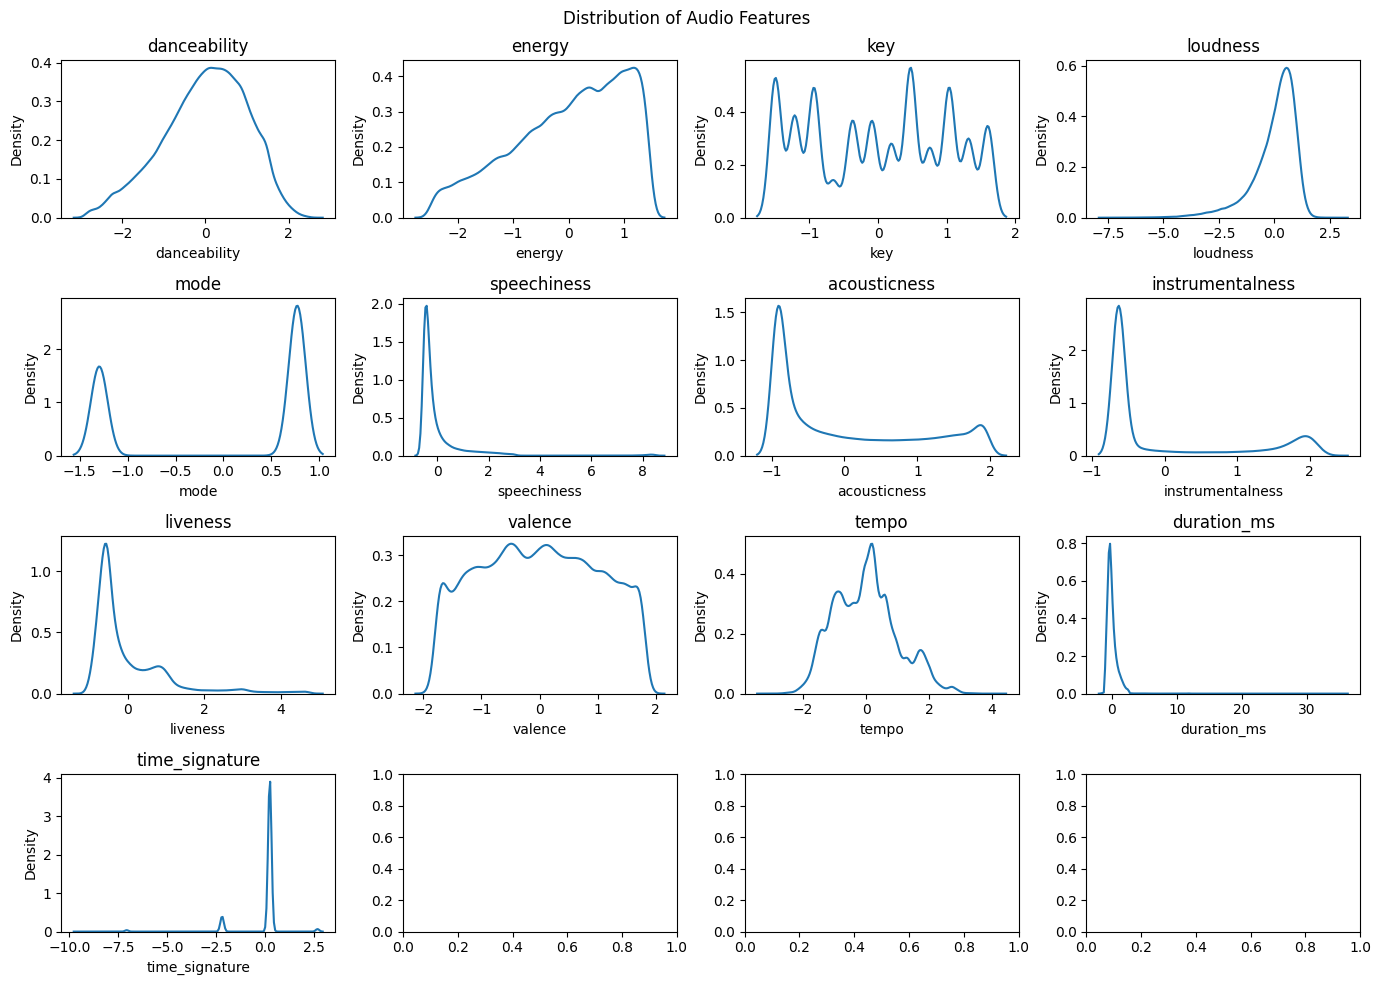

In [50]:
# Select only the audio features columns from the DataFrame
audio_features = df.iloc[:, 4:]

# Create a 4x3 grid of subplots
))

# Loop through each audio feature and plot its distribution on a separate subplot
for i, feature in enumerate(audio_features.columns):
    row = i // 4
    col = i % 4
    sns.kdeplot(audio_features[feature], ax=axs[row, col])
    axs[row, col].set_title(feature)

# Add a main title to the figure
fig.suptitle("Distribution of Audio Features")

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

> Analysis:

> We can see, based on these graphs, that we have many distinct shapes to our audio feature distributions. We have bimodal distributions, many-modal distribitions, bell-curves, right-skews, left-skews, and plain old weird shapes. In general, I believe the diversity of these features will provide many angles of categorization for our clustering algorithm.

## 7. Correlation analysis

Use pandas and seaborn to compute and visualize the correlations between different audio features. This can help you understand how the audio features are related to each other.

<ipython-input-21-e1f2abc5a421>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


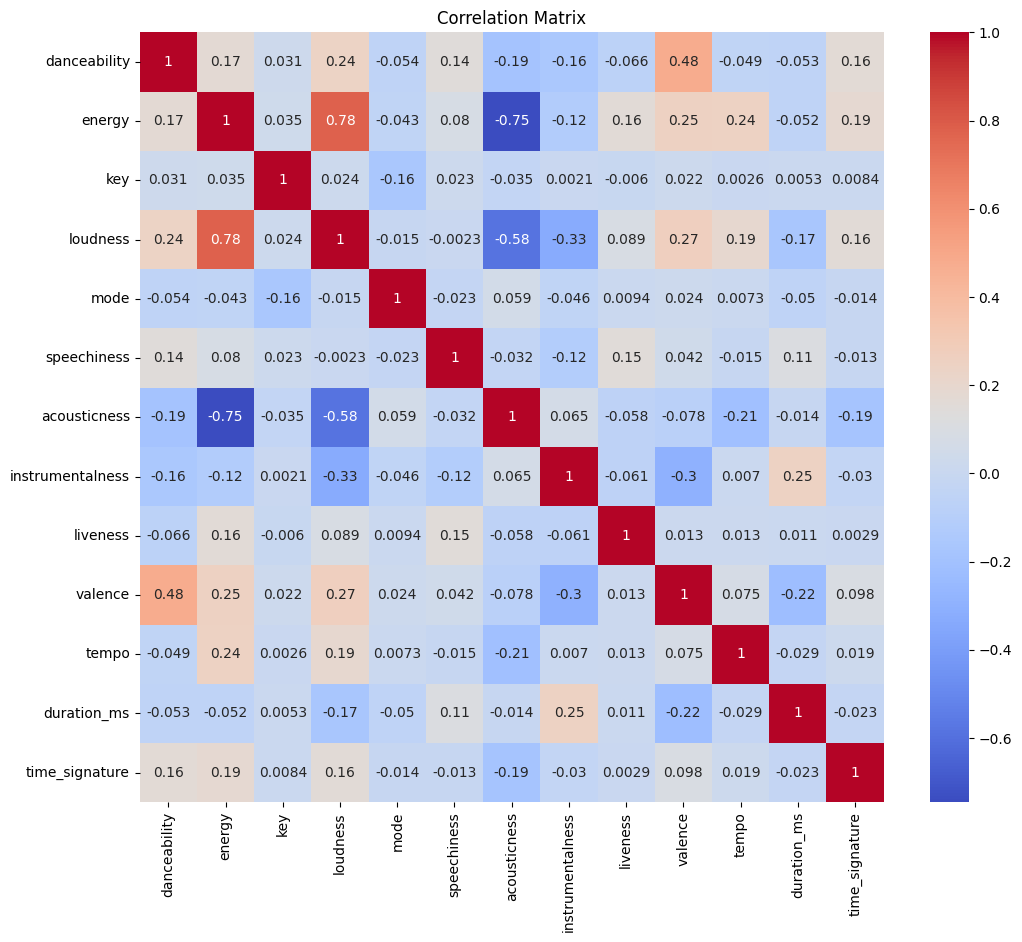

In [21]:
corr = df.corr()

# Create heat map figure
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()

> Analysis:

> This heat map is a great visualization, even though most of the outcomes we get from the outstanding correlations are somewhat obvious. For example, I would expect loudness & energy to be heavily correlated (+0.77), as well as valence & danceability to be decently positively-correlated (+0.48) (note: valence is the emotion of a song, how happy or sad it is). 

> However, I find it interesting how acousticness is so crucial to determining a song's energy. Acousticness and energy have a strong negative correlation of -0.74. This might be due to the aforeseen collinearity of energy & loudness, because acoustic songs are typically quieter than non-acoustic songs, and that is indicitave of a more laid-back energy.

> There are a few more interesting relationships, such as valence & instrumentalness (-0.32) and instrumentalness & duration (+0.28), but overall what is important to consider from this graph is the multicollinearity of variables. Our clustering algorithm might be impacted by the fact that energy, loudness, and apparently, acousticness are already closely linked. Ideally, this heat map would not display extreme heat or extreme cold... it would be room temperature (apologies for the over-zealous metaphor), so hopefully our other sections of EDA will lend to more positive expectations for clustering!

## 8. Grouping and aggregating

Use pandas to group the data by different categories, such as genre or artist, and compute aggregate statistics for each group. This can help you understand how the audio features vary across different categories.

In [22]:
df.groupby('track_genre').mean()

<ipython-input-22-9ddf37797f58>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('track_genre').mean()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
track_genre,,,,,,,,,,,,,
a cappella,0.525021,0.488693,5.492308,-8.159856,0.712821,0.054722,0.581497,0.000392,0.181641,0.442266,115.859262,229730.153846,3.897436
abstract,0.395765,0.376724,5.123457,-17.964309,0.574074,0.080456,0.524963,0.723031,0.140953,0.201117,115.286000,320712.228395,3.802469
abstract beats,0.648292,0.621613,5.649635,-8.493942,0.489051,0.139098,0.223787,0.399107,0.211001,0.497103,115.249540,199420.445255,3.919708
abstract hip hop,0.652565,0.747513,5.707792,-7.052662,0.584416,0.216194,0.181378,0.042200,0.241658,0.530742,112.392786,235224.733766,3.941558
abstract idm,0.530320,0.675272,4.782857,-9.947823,0.577143,0.087992,0.185250,0.663498,0.195271,0.243890,128.151983,318864.965714,3.862857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolo,0.554300,0.668540,5.520000,-10.468180,0.720000,0.064106,0.201676,0.153321,0.181574,0.592579,128.644250,237460.510000,3.910000
zouglou,0.747561,0.837734,5.633094,-6.258468,0.676259,0.130363,0.270127,0.010815,0.200388,0.829532,127.985036,279925.625899,3.971223
zouk,0.670126,0.780674,5.348148,-7.501889,0.540741,0.053119,0.158756,0.035931,0.181376,0.748800,128.832867,282770.170370,3.985185


> Analysis:

> We can see just from the few lines represented by this dataframe that there are noticeable differences between genres in the average values of each audio features. This bodes well for our clustering algorithm.

> We can take that initial notice a step further by displaying the descriptive statistics for this new grouped-and-aggregated-by-genre data...

In [23]:
df.groupby('track_genre').mean().describe()

<ipython-input-23-a8766ac271f8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('track_genre').mean().describe()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1.140000e+03,1140.000000
mean,0.549188,0.634105,5.317248,-8.855888,0.627929,0.082022,0.318474,0.220517,0.197548,0.496541,122.095080,2.586044e+05,3.901279
std,0.129353,0.198907,0.387142,3.741208,0.137003,0.083772,0.280181,0.252038,0.046354,0.171162,9.687332,7.934750e+04,0.112435
min,0.157449,0.096228,3.661417,-25.656611,0.175879,0.032381,0.000586,0.000004,0.110218,0.050860,93.078817,7.905965e+04,3.180328
25%,0.466938,0.520187,5.065669,-9.997561,0.530278,0.050250,0.082325,0.014898,0.170680,0.382844,116.695272,2.201330e+05,3.862751
50%,0.559930,0.676098,5.319692,-7.788604,0.615773,0.063432,0.224173,0.098512,0.191942,0.504742,122.247184,2.384572e+05,3.941582
75%,0.648006,0.766994,5.573226,-6.569233,0.727273,0.084876,0.517348,0.398573,0.216195,0.606739,127.153467,2.828261e+05,3.978761
max,0.853458,0.963347,6.478723,-3.520184,0.990000,0.930515,0.986598,0.902280,0.759775,0.913953,170.480209,1.445947e+06,4.111111


> Analysis:

> I especially have my eye on the standard deviation row. Because this is displaying the standard deviation between genres, I am looking for those columns with higher standard deviations, which I believe will be the most important for our clustering algorithm. The following series displays our audio features, in order of highest-to-lowest standard deviation across genres...

In [24]:
df.groupby('track_genre').mean().describe().loc['std'].sort_values(ascending=False)

<ipython-input-24-fe14d25b94d9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('track_genre').mean().describe().loc['std'].sort_values(ascending=False)


duration_ms         79347.496254
tempo                   9.687332
loudness                3.741208
key                     0.387142
acousticness            0.280181
instrumentalness        0.252038
energy                  0.198907
valence                 0.171162
mode                    0.137003
danceability            0.129353
time_signature          0.112435
speechiness             0.083772
liveness                0.046354
Name: std, dtype: float64

> Analysis:

> Wow! Duration is the clear winner! I did not think about duration as a key factor to determining genre before, but now it has me thinking: do tracks of the same genre usually have similar duration? I want to say the answer is yes, but now we can do even more analysis, by finding the average standard deviation within each genre (instead of across all genres). I will perform this calculation for all categories, not just duration_ms, to see which features have the most average variation within individual genres.

In [25]:
df.groupby('track_genre').std().describe().loc['mean'].sort_values(ascending=False)

<ipython-input-25-0149403a65c8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('track_genre').std().describe().loc['mean'].sort_values(ascending=False)


duration_ms         71670.953250
tempo                  26.350358
key                     3.537465
loudness                3.017976
mode                    0.461758
time_signature          0.339676
valence                 0.202402
instrumentalness        0.195702
acousticness            0.182604
liveness                0.154415
energy                  0.152834
danceability            0.111776
speechiness             0.051688
Name: mean, dtype: float64

> Analysis:

> We can see that for many of this features, their variation across genres is matched, or even outmatched, by variation within genres. This does not bode well for our clustering algorithm, because it means each genre "cluster" will be stretched and not solidly defined. We can create a metric for each feature, which is simply its value in the first list (across-genre deviation) divided by its value in the second list (in-genre deviation). The higher the number, the better we'll be able to cluster songs by that feature...

In [26]:
across_genre = df.groupby('track_genre').mean().describe().loc['std'].sort_values(ascending=False)
within_genre = df.groupby('track_genre').std().describe().loc['mean'].sort_values(ascending=False)

clusterability = pd.Series(index=across_genre.index, name="clusterability")

for feature in clusterability.index:
    clusterability[feature] = across_genre[feature] / within_genre[feature]

clusterability.sort_values(ascending=False)

<ipython-input-26-82a39a8a12c4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  across_genre = df.groupby('track_genre').mean().describe().loc['std'].sort_values(ascending=False)
<ipython-input-26-82a39a8a12c4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  within_genre = df.groupby('track_genre').std().describe().loc['mean'].sort_values(ascending=False)
<ipython-input-26-82a39a8a12c4>:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusterability = pd.Series(index=across_genre.index, name

speechiness         1.620742
acousticness        1.534363
energy              1.301453
instrumentalness    1.287864
loudness            1.239642
danceability        1.157254
duration_ms         1.107108
valence             0.845653
tempo               0.367636
time_signature      0.331007
liveness            0.300193
mode                0.296698
key                 0.109440
Name: clusterability, dtype: float64

> Analysis:

> I believe this list provides us with the most valuable metric leading into our clustering. Based on this understanding, we can perform two clustering strategies, one including all features, then one only with features that have a cluster score greater than 1 (i.e., that have more across-genre deviation than within-genre deviation). We can then compare the two clusters using our performance metrics, and learn a lot about feature analysis.

> (I am very proud of this new "clusterability" metric I thought of... it might be the coolest outcome of this project LOL)

# Transition to the Model

Now, as a reminder, our goal for creating the model will be to test this "clusterability" metric. Our results will either show that reducing

# Model: k-Nearest Neighbors Clustering

For our model, we will be using the k-nearest neighbors clustering algorithm. We will compare two models, one which uses all audio features, and one which uses only the audio features which we found to have high *clusterability* scores. If you recall from our EDA file, we created a metric similar to the Calinski Harabaz index [1] which measures the proportion between standard deviation within and between genres. Rather than using that measure for clusters, I used it in the EDA step to determine which features would promote tightness within and seperation between clusters.

To evaluate each model, we will use the following performance metrics:
* [1] Calinski Harabaz Index
  * $\ CH = \frac{B / (k - 1)}{W / (n - k)} $
  * $\ B $ is the between-cluster sum of squares
  * $\ W $ is the within-cluster sum of squares
* [2] Silhouette Score
  * $\ s(i) = \frac{b-a}{max(b, a)} $
  * $\ a $ is the mean intra-cluster distance
  * $\ b $ is the mean nearest-cluster distance
* [3] Davis Bouldin Index
  * $\  DB = \frac{1}{k} \sum_{i=1}^{k} max{\substack{i \neq j}} R{\substack{ij}} $
  * $\ R{\substack{ij}} = \frac{s{\substack{i}} + s{\substack{j}}}{d{\substack{ij}}} $
* [4] Normalized Mutual Information
  * $\ NMI(X,Y) = \frac{I(X,Y)}{\sqrt{H(X)H(Y)}} $
  * $\ I() $ is the mutual information metric
  * $\ H() $ is the entropy metric

### References

>[1] https://www.tandfonline.com/doi/abs/10.1080/03610927408827101.

>[2] https://www.sciencedirect.com/science/article/pii/0377042787901257.

>[3] https://ieeexplore.ieee.org/abstract/document/4766909.

>[4] https://dl.acm.org/doi/abs/10.5555/2074094.2074140.

# 1. Import required libraries

In [27]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, normalized_mutual_info_score

from google.colab import drive
drive.mount('/content/drive')

base_dir = "drive/MyDrive/Courses/CS 539 - Machine Learning/genuine_genres/project_phillips/data/clean/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Load the data

In [28]:
# Read audio features file to dataframe
df = pd.read_csv(base_dir + "audio_features_z_scaled.csv")

# Define input and output variables
X = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms', 'time_signature']]
y = df['track_genre'].values.ravel()

# 3. Split the data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [30]:
# Define control model independent train and test variables
ctl_X_train = X_train
ctl_X_test = X_test

# Define dimensionality-reduced model independent train and test variables
rdc_X_train = X_train[['danceability', 'energy', 'loudness', 'speechiness',
                       'acousticness', 'instrumentalness', 'duration_ms']]
rdc_X_test = X_test[['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'duration_ms']]

# 4. Train the models

In [31]:
# Determine starting k by number of songs in each genre
n_songs = len(y_train)
n_genres = len(np.unique(y_train))  # i.e., desired number of clusters
n_neighbors = n_songs // n_genres - 1

n_neighbors

125

In [34]:
# Control model
ctl_knn = KNeighborsClassifier(n_neighbors=319)
ctl_knn.fit(ctl_X_train, y_train)

KNeighborsClassifier(n_neighbors=319)

In [36]:
# Dimensionality-reduced model
rdc_knn = KNeighborsClassifier(n_neighbors=319)
rdc_knn.fit(rdc_X_train, y_train)

KNeighborsClassifier(n_neighbors=319)

# 5. Test the models

## 5.1 Test the control model

In [37]:
# Test the model
ctl_y_pred = ctl_knn.predict(ctl_X_test)
ctl_accuracy = accuracy_score(y_test, ctl_y_pred)
ctl_precision = precision_score(y_test, ctl_y_pred, average=None)
ctl_recall = recall_score(y_test, ctl_y_pred, average=None)
ctl_f1 = f1_score(y_test, ctl_y_pred, average=None)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Compute clustering performance metrics
ctl_ch_score = calinski_harabasz_score(ctl_X_test, ctl_y_pred)
ctl_silhouette = silhouette_score(ctl_X_test, ctl_y_pred)
ctl_db_index = davies_bouldin_score(ctl_X_test, ctl_y_pred)
ctl_nmi_score = normalized_mutual_info_score(y_test, ctl_y_pred)

In [39]:
print("Accuracy: ", ctl_accuracy)
print("Precision: ", np.mean(ctl_precision))
print("Recall: ", np.mean(ctl_recall))
print("F1 Score: ", np.mean(ctl_f1))
print("Calinski Harabasz Index: ", ctl_ch_score)
print("Silhouette Score: ", ctl_silhouette)
print("Davies Bouldin Index: ", ctl_db_index)
print("Normalized Mutual Information Score: ", ctl_nmi_score)

Accuracy:  0.04658961780438458
Precision:  0.034998972215633535
Recall:  0.0425069002050525
F1 Score:  0.02955697432077622
Calinski Harabasz Index:  61.60705362879036
Silhouette Score:  -0.23244007393510444
Davies Bouldin Index:  3.394689515004052
Normalized Mutual Information Score:  0.4770525074585134


## 5.2 Test the dimensionality-reduced model

In [40]:
# Test the model
rdc_y_pred = rdc_knn.predict(rdc_X_test)
rdc_accuracy = accuracy_score(y_test, rdc_y_pred)
rdc_precision = precision_score(y_test, rdc_y_pred, average=None)
rdc_recall = recall_score(y_test, rdc_y_pred, average=None)
rdc_f1 = f1_score(y_test, rdc_y_pred, average=None)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Compute clustering performance metrics
rdc_ch_score = calinski_harabasz_score(rdc_X_test, rdc_y_pred)
rdc_silhouette = silhouette_score(rdc_X_test, rdc_y_pred)
rdc_db_index = davies_bouldin_score(rdc_X_test, rdc_y_pred)
rdc_nmi_score = normalized_mutual_info_score(y_test, rdc_y_pred)

In [42]:
print("Accuracy: ", rdc_accuracy)
print("Precision: ", np.mean(rdc_precision))
print("Recall: ", np.mean(rdc_recall))
print("F1 Score: ", np.mean(rdc_f1))
print("Calinski Harabasz Index: ", rdc_ch_score)
print("Silhouette Score: ", rdc_silhouette)
print("Davies Bouldin Index: ", rdc_db_index)
print("Normalized Mutual Information Score: ", rdc_nmi_score)

Accuracy:  0.04539785482664006
Precision:  0.03160591930811911
Recall:  0.04135302531121566
F1 Score:  0.02799307571285674
Calinski Harabasz Index:  215.89245252299958
Silhouette Score:  -0.22366777460971557
Davies Bouldin Index:  3.177261545017755
Normalized Mutual Information Score:  0.4770464925508423
